### Evaluating the Mask R-CNN Torchscript model

In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from pycocotools import mask as maskUtils
from matplotlib.patches import Patch
import torch
import torchvision
import torchdata
from ceruleanml import plot, data_pipeline
import random
# Set the random seed
seed=0 # we need to set this for torch datapipe separately
random.seed(seed)

In [2]:
model_path = "/slickformer/data/models/2023_02_18_00_38_07_4cls_rn152_pr512_px1024_1440min_maskrcnn_scripting_cpu_model.pt"
scripted_model = torch.jit.load(model_path)

In [3]:
torch.cuda.is_available()

True

### Grabbing a test image to inspect

In [4]:
#test_scene = "S1A_IW_GRDH_1SDV_20210220T174437_20210220T174502_036677_044F60_51BC" # lots of slicks, but no vessel
test_scene = "S1A_IW_GRDH_1SDV_20200805T144239_20200805T144304_033773_03EA39_1ED1" # one old slick

data_dir = Path("../data/partitions/test_tiles_context_0/")

l = data_dir/"tiled_images"

imgs = list(l.glob("*"))

test_path = [i for i in imgs if test_scene in i.as_posix()][0]

#### Load annotations and decode them to numpy arrays

In [5]:
with open(data_dir/"instances_CeruleanCOCO.json", 'r') as f:
    annotations = json.load(f)

mask_cat_ids, mask_arrs = data_pipeline.decode_masks(test_scene, annotations)

In [6]:
annotations['categories']

[{'supercategory': 'slick', 'id': 0, 'name': 'background'},
 {'supercategory': 'slick', 'id': 1, 'name': 'infra_slick'},
 {'supercategory': 'slick', 'id': 2, 'name': 'natural_seep'},
 {'supercategory': 'slick', 'id': 3, 'name': 'coincident_vessel'},
 {'supercategory': 'slick', 'id': 4, 'name': 'recent_vessel'},
 {'supercategory': 'slick', 'id': 5, 'name': 'old_vessel'},
 {'supercategory': 'slick', 'id': 6, 'name': 'ambiguous'}]

#### Create a new image to draw on

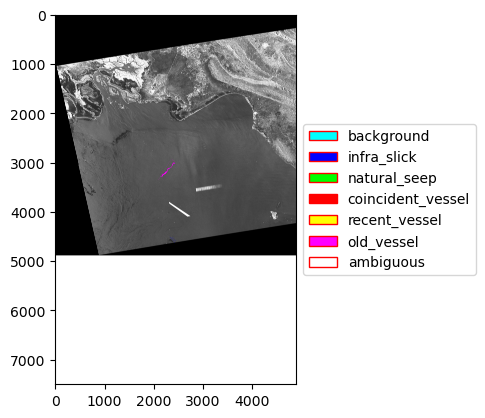

In [7]:
test_im_pil_channels = Image.open(test_path).split()

test_im_pil_vv = test_im_pil_channels[0]
plot.plot_instance_masks(test_path, mask_arrs, mask_cat_ids)

In [8]:
source_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[annotations])
labels_pipe = torchdata.datapipes.iter.IterableWrapper(iterable=[annotations])
source = (
    source_pipe.get_scene_paths("/slickformer/data/partitions/test_tiles_context_0/")  # get source items from the collection
    .read_tiff()
)

In [9]:
labels = (
    labels_pipe.decode_masks()
    .map(lambda x: x[0])
)

In [10]:
channel_first = lambda x: (np.moveaxis(x['image'],2,0), x['masks']) # needs to happen after pil crop
normalize = lambda x: (x[0]/255, x[1]) # faster if applied post pil crop by about 1 second
to_tensor = lambda x: (torch.Tensor(x[0]), x[1]) # we only need the mrcnn model as a cpu tensor for inference, then compute eval w numpy on cpu

In [11]:
trn_dp, val_dp, tst_dp = (
    source.zip(labels)
    .random_crop_mask_if_exists(2000,2000)
    .map(channel_first)
    .map(normalize)
    .map(to_tensor)
    # .shuffle()
    .random_split(
        total_length=len(source),
        weights={"trn": 0.7, "val": 0.2, "tst": 0.1},
        seed=seed,
    )
)

In [12]:
%%time
x=next(iter(trn_dp))

CPU times: user 2.7 s, sys: 196 ms, total: 2.9 s
Wall time: 937 ms


maskrcnn wants a list of 3D arrays with length of list as batch size

In [13]:
# evaluate model:
scripted_model.eval()

with torch.no_grad():
    losses, pred_list = scripted_model([x[0]])
pred_list[0]['masks'] = np.squeeze(pred_list[0]['masks']) # we modify this to match expected shape for plotting

/root/mambaforge/envs/slickformer/lib/python3.10/site-packages/torch/nn/modules/module.py:1501: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return forward_call(*args, **kwargs)
/root/mambaforge/envs/slickformer/lib/python3.10/site-packages/torch/nn/modules/module.py:1501: UserWarning: operator() sees varying value in profiling, ignoring and this should be handled by GUARD logic (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/third_party/nvfuser/csrc/parser.cpp:3777.)
  return forward_call(*args, **kwargs)
code/__torch__/torchvision/models/detection/mask_rcnn.py:107: UserWarning: RCNN always returns a (Losses, Detections) tuple in scripting


pred_list details

* len of pred_list is always 1 if input is 1
* bbox coords are not normalized. 
* dict values are tensors until post processed with conf thresholding.
* length of value list indicates how many instances detected both low and high confidence
* Mask R-CNN mask values are not logits, they are 0 to 1 confidence probabilities. the torchscript model applies softmax unlike the fastai unet model where we do that after inference.
* bbox coord order is xmin, ymin, xmax, ymax, the same as icevision record collection bbox format

In [14]:
len(pred_list)

1

While we annotated more than 3 classes, in reality the class hierarchy was too specific and confusing for annotators. so we remapped the vessel categories to a single category to train the maskrcnn model that we used for inference. Therefore, when plotting and computing the confusion matrix, we need to convert the plot labels and coco annotations to 3 classes (infra, natural, vessel).

In [15]:
from ceruleanml.inference import apply_conf_threshold_instances, apply_conf_threshold_masks
from ceruleanml.data_creation import class_dict
selected_classes_3_class_model = ['background', 'infra_slick', 'natural_seep', 'coincident_vessel']
selected_classes = [key for key in selected_classes_3_class_model if key in class_dict]
bbox_conf_threshold = .2
pred_dict = apply_conf_threshold_instances(pred_list[0], bbox_conf_threshold=bbox_conf_threshold)

In [16]:
pred_dict['scores']

[tensor(0.8681), tensor(0.2718)]

We can extract the first mask in the first sample's prediction and plot it by converting it to a numpy array.

In [17]:
import skimage.io as skio

/root/mambaforge/envs/slickformer/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


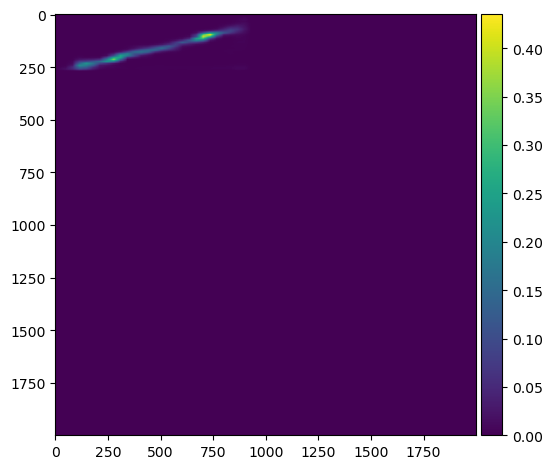

In [18]:
skio.imshow(pred_dict['masks'][0].detach().cpu().numpy())

In [19]:
high_conf_class_arrs = apply_conf_threshold_masks(pred_dict, mask_conf_threshold=.05, size=2000)

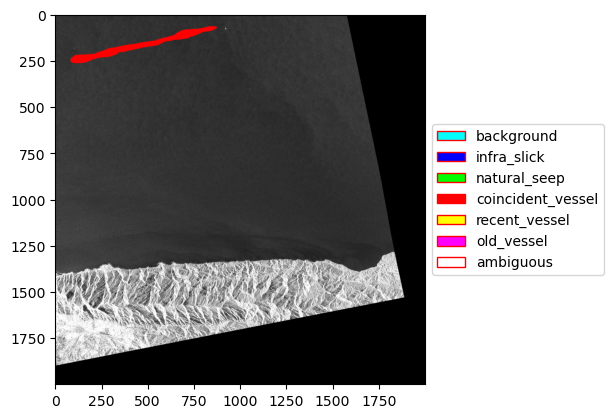

In [20]:
plot.plot_instance_masks(x[0][0], high_conf_class_arrs, pred_dict['labels'], class_list=selected_classes, outline_only=True)

TODO plot a histogram of confidence scores for a pred_list

In [ ]:
import matplotlib.pyplot as plt

test = pred_list[0]['masks'][0,0,:,:].detach().cpu().numpy().flatten()

# scratch code
# np.ma.masked_where(test!=0, test)

# plt.hist(np.ma.masked_where(test!=0, test), bins = 300)

After inference, we need to post process the result.

In [ ]:
from torchvision import transforms
from PIL import Image
import torch

# Convert the tensor to a PIL image
pil_image = transforms.ToPILImage()(x[0][0])

In [ ]:
pil_image

In [ ]:
bbox_conf_threshold = .5

pred_dict = apply_conf_threshold_instances(pred_list[0], bbox_conf_threshold=bbox_conf_threshold)

In [ ]:
merged_class_arr = apply_conf_threshold_masks(pred_dict, mask_conf_threshold=.5, size=2000)

In [ ]:
apply_conf_threshold_masks??

The output of the last thresholding step is a 2D array of classes. we use this for pixel-wise evaluation. 

In [ ]:
merged_class_arr.shape

In [ ]:
skio.imshow(test_img[:,:,0])

In [ ]:
torch.unique(merged_class_arr)

In [ ]:
import skimage.io as skio

This array has two values, 2 for vessels and 0 for background

In [ ]:
%matplotlib inline
skio.imshow(merged_class_arr.detach().cpu().numpy())

Next, we set up the data loader.

## Confusion Matrix Comparison for Unet and MaskRCNN

In this section we create and compare pixel-wise confusion matrices and instance-wise confusion matrices.

In [ ]:
from ceruleanml.evaluation import get_cm_for_torchscript_model_unet, get_cm_for_torchscript_model_mrcnn
from ceruleanml.data import class_mapping_coco
from icevision.metrics.confusion_matrix import SimpleConfusionMatrix
from icevision.metrics.confusion_matrix.confusion_matrix import MatchingPolicy
from icevision.models.checkpoint import model_from_checkpoint

The pixel wise mrcnn cm is correct. TODO this doesn't work with negative samples, only the instance confusion matrix does.

In [ ]:
get_cm_for_torchscript_model_mrcnn??

In [ ]:
from tqdm import tqdm
cm_mrcnn, f1_mrcnn = get_cm_for_torchscript_model_mrcnn(
    valid_ds, scripted_model, save_path=icevision_experiment_dir, mask_conf_threshold=.01, bbox_conf_threshold=.7, num_classes=3, normalize=None, class_names=["background", "infra_slick", "recent_vessel"], title="Torchvision MaskR-CNN Confusion Matrix: 20_Jul_2022_00_14_15"
)


In [ ]:
cm_mrcnn, f1_mrcnn = get_cm_for_torchscript_model_mrcnn(
    valid_ds, scripted_model, save_path=icevision_experiment_dir, mask_conf_threshold=.01, bbox_conf_threshold=.7, num_classes=3, normalize="true", class_names=["background", "infra_slick", "recent_vessel"], title="Torchvision MaskR-CNN Confusion Matrix: 20_Jul_2022_00_14_15"
)


In [ ]:
%matplotlib inline
_ = cm.finalize()

cm.plot(figsize=5, normalize=None)

In [ ]:
S1A_IW_GRDH_1SDV_20200724T020738_20200724T020804_033590_03E494_B457"